# Human Variation and Diesase Coalescent Computer Lab
---

Welcome to the coalescent computer lab! Here we'll explore some fundamentals of the coalescent using exploratory data analysis (i.e. computing summary statistics / visualization) and simulation. We'll learn about & employ a powerful coalescent simulator called `msprime`, which allows us to efficiently generate genealogies under a given demography and subsequently sprinkle mutations on these genealogies to generate sequence data. Coalescent simulation is a very important tool to be equipped with for the modern population geneticist for a number of reasons...

* It allows us to develop intuition for a simple generative model that can help to explain patterns in real data
* We can use simulations to compare the accuracy of methods and see where they break down or succeed
* Simulation can be used in inference, for instance to obtain monte carlo estimates for particular steps of a intractable model or perform approximate Bayesian inference (ABC)

A quick note about computing: The environment we are in is called a `jupyter notebook`. A `jupyter notebook` is an interactive computational portal that allows us to make documents that combine simple text formats (markdown / latex) and code. This is quite powerful as we can write up analyses and explorations in the notebook and annotate visualizations & code with text and even math. Jupyter is primarily geared for `python` but one can actually change the "kernel" of the notebook to use `R` and even `julia`. Today we'll actually be using a very interesting python package called `rpy2` which allows us to run `R` commands in a `python` “kernel”. We can even pass objects created in python into an `R` code block. How this works will become more clear as we get started. 

Alright, now let us begin by importing various libraries that we'll be using in this notebook!

## Imports / Configuration

Here we load a jupyter extension that allows us to use `rpy2` to pass objects back and forth between `R` and `python` code blocks. 

In [24]:
%load_ext rpy2.ipython

This is how we import packages in python. `numpy` is a python package for creating, manipulating and operating on arrays. As we mentioned previously, `msprime` is a python package for performing coalescent simulations. It expands upon [Dick Hudson's](http://home.uchicago.edu/rhudson1/), a UChicago professor and coalescent pioneer, `ms` software. `tskit` is a complementary package that allows us to work with the output of `msprime` simulations. We will also load the `Ipython` package which will allow us to better visualize the coalescent trees we simulate. 

In [5]:
import numpy as np
import msprime 
import IPython
import tskit

Here is a quick example of how we can pass python objects into `R`. Lets first create a simple matrix $\mathbf{A}$ 

In [5]:
A = np.array([[1,2], [3, 4]])
A

array([[1, 2],
       [3, 4]])

Lets now import $\mathbf{A}$ into `R`. To use `R` run the `%%R` command in the top of the code block ...

In [6]:
%%R -i A
A

     [,1] [,2]
[1,]    1    2
[2,]    3    4


Cool! That seems to work. Lets try making simple plot ...

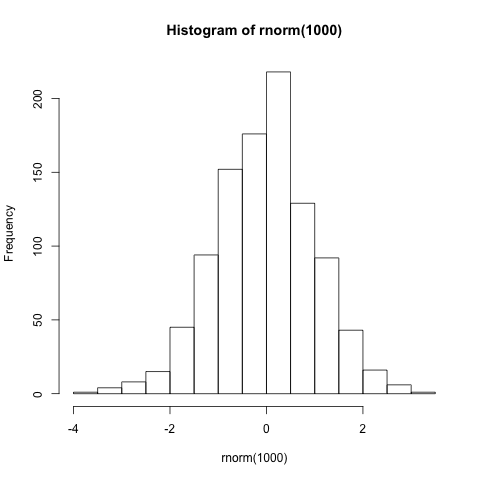

In [7]:
%%R
hist(rnorm(1000))

We are now equipped to run the rest of the notebook ...

---

## Coalescent simulation using `msprime`

msprime is a widely used software for runnning coalescent simulations. There is a tutorial located here (https://msprime.readthedocs.io/en/stable/tutorial.html). This is a really nice [jupyter notebook](https://github.com/jhmarcus/spg-chapter/) written by [Jerome Kelleher](https://github.com/jeromekelleher), the author of `msprime`. Click the launch binder button at the bottom of the page. We strongly encourage you to change parameters in the notebook and build intuition on how that affects properties of coalescent trees and see how it matches your predictions from the theory we've learned in class.

## Writing your own coalescent simulations

Let's start by running our first simulation! To do this we will use the function msprime.simulate(), passing in the sample size and effective population size $N_e$ as arguments. Here we are simulating a sample size of 4 with an effective population size of 1,000. Since we haven't provided a recombination rate, we are only simulating a single coalescent tree. Because we didn't set a seed and the coalescent is a random process, every time you run the code block you should observe a different tree.   

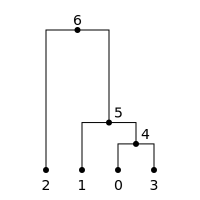

In [28]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000)
tree = tree_sequence.first()
IPython.display.SVG(tree.draw())

Now that we have simulated a coalescent tree, we might want to learn some properties of it. For example, let's find the $T_{MRCA}$ for our tree. To do this we can use tree.time() which outputs the time to the most recent common ancestor in generations. 

In [29]:
T_mrca = tree.time(tree.root)
T_mrca

4723.116585893688

However, this is just one simulation. Let's run 10,000 simulations and find the average $T_{MRCA}$.

In [30]:
num_reps = 10000
T_mrca = np.zeros(num_reps)
for j, ts in enumerate(msprime.simulate(sample_size=4, Ne=1000,num_replicates=num_reps)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca)

3009.4304092186853

**Question** Compare the result above to our theoretical expectation for $T_{MRCA}$ for $n=5$ and $N_e = 1000$. Then re-run the 10,000 simulations for $N_e = 10000$, do you expect the average $T_{MRCA}$ to increase or decrease, why? 

**Answer** 

In [27]:
%%R 
# your R code goes here

# Theoretical expectation for N=1000
print(4*1000 * (1 - (1/4)))

# Theoretical expectation for N=10000
print(4*10000 * (1 - (1/4)))



[1] 3000
[1] 30000


In [31]:
# your python code goes here 
num_reps = 10000
T_mrca = np.zeros(num_reps)
for j, ts in enumerate(msprime.simulate(sample_size=4, Ne=10000,num_replicates=num_reps)):
    tree = ts.first()
    T_mrca[j] = tree.time(tree.root)
np.mean(T_mrca)

30206.59400550834

### Adding Recombination  

While simulating a single coalescent tree is useful, often times we are interested in a locus of a specific length under the influence of recombination. This will create a series of coalescent trees over the length of our locus. In `msprime` we can use the same msprime.simulate() function and add two arguments, length and recombination_rate. The length parameter is the number of base pairs and recombination rate is in units of per base per generation. Here we are simulating trees across over a 10kb region with a recombination rate of $2×10^{−8}$ per base per generation, with a diploid effective population size of 1000   

In [13]:
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, recombination_rate=2e-8, random_seed=31)
# Let's look at the trees we made and the intervals they occur over 
for tree in tree_sequence.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    print(tree.draw(format="unicode"))

--------------------
tree 0: interval = (0.0, 1506.6544063171964)
   6     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 3 1 2  

--------------------
tree 1: interval = (1506.6544063171964, 2738.340972628989)
   8     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 3 1 2  

--------------------
tree 2: interval = (2738.340972628989, 8361.43215148743)
   7     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 3 1 2  

--------------------
tree 3: interval = (8361.43215148743, 10000.0)
   8     
 ┏━┻━┓   
 ┃   5   
 ┃  ┏┻┓  
 4  ┃ ┃  
┏┻┓ ┃ ┃  
0 3 1 2  



We have printed out the series of 4 coalescent trees for our locus and the intervals they occur over.

### Adding mutation

So far we have simulated a region of chromosome with recombination, now want to put mutations down onto our sequence of coalescent trees. Mutations are generated in msprime by throwing mutations down on the branches of trees at a particular rate. The mutations are generated under the infinite sites model, and so each mutation occurs at a unique (floating point) point position along the genomic interval occupied by a tree. The mutation rate for simulations is specified using the mutation_rate parameter of msprime.simulate(). Below we will simulate 50kb or non-recombiing chromosome and add mutations onto the coalescent tree.

Mutation @ position 1239.40 over node 13
Mutation @ position 8842.09 over node 13
Mutation @ position 11759.03 over node 11
Mutation @ position 15806.67 over node 2
Mutation @ position 16177.68 over node 13
Mutation @ position 16762.10 over node 2
Mutation @ position 17312.52 over node 2
Mutation @ position 18349.37 over node 12
Mutation @ position 29771.91 over node 2
Mutation @ position 34897.51 over node 17
Mutation @ position 41735.75 over node 12
Mutation @ position 46566.56 over node 10
Mutation @ position 49697.99 over node 14


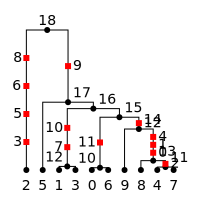

In [6]:
tree_sequence = msprime.simulate(
    sample_size=10, Ne=1000, length=50e3, mutation_rate=2e-8, random_seed=30)
tree = tree_sequence.first()
for site in tree.sites():
     for mutation in site.mutations:
            print("Mutation @ position {:.2f} over node {}".format(
                site.position, mutation.node))
IPython.display.SVG(tree.draw())

From here we can create a genotype matrix for our samples. Python and R store integer numbers in different formats. The int8 command will convert python’s format into R’s format so we can work with it later using R code.

In [7]:
G = tree_sequence.genotype_matrix() 
# We need to convert data type so we can work with the genotype matrix in R
G = np.int8(G)
G

array([[0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 1]], dtype=int8)

In the genotype matrix each individual is a separate column and each mutation is a row. If we look at individual 2, we see that the should have a "1" indicating that they have the mutation for mutations 3, 5, 6, and 8. Remember that python indexes from zero individuals are numbered 0,1,..,9. So individual 2 is the third column of the genotype matrix.

**Question 2** Write a function to calculate the site frequency spectrum from the genotype matrix. Use your function to plot the SFS for G. 

sfs
1 2 3 4 9 
4 4 3 1 1 


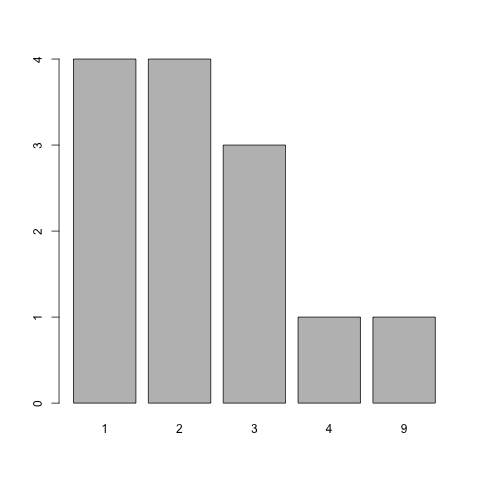

In [26]:
%%R -i G
# R code goes here
SFS <- function(G) { 
    G <- t(G)
    sfs <- colSums(G) 
    out <- table(sfs) 
    return(out)
}

barplot(SFS(G))

In [ ]:
## python code goes here 

We can also use `tskit` to calculate some familar summary statistics directly from our tree sequence object. tree_sequence.diversity() calculates nucleotide diversity, $\pi$. tree_sequence.segregating_sites() calculates the number of segregating sites, the argument span_normalise=False tells the function to give us the number of segregating sites rather than the density of segregating sites. Finally, tree_sequence.Tajimas_D() calculates Tajima's D for our sample.  

In [21]:
# Nucleotide diversity (pi)
print(tree_sequence.diversity()) 
# Number of segregating sites 
print(tree_sequence.segregating_sites(span_normalise=False))
# Tajima's D
print(tree_sequence.Tajimas_D())


8.711111111111114e-05
13.0
-0.2374181244410529


## Simulating under different demographic models 

Thus far we have focused on running coalescent simulations under a constant population size model. While these models are very important for building intuition and establishing theoretical expectations, we know that human populations have not had a constant population size. Now we will practice simulations under different situations, including population growth and population bottlenecks. 

0.00015288888888888888
23.0
-0.2831596158247124


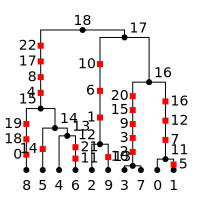

In [121]:
tree_sequence = msprime.simulate(
    sample_size=10, Ne=1000, length=50e3, mutation_rate=5e-8, random_seed=13)

# Nucleotide diversity (pi)
print(tree_sequence.diversity()) 
# Number of segregating sites 
print(tree_sequence.segregating_sites(span_normalise=False))
# Tajima's D
print(tree_sequence.Tajimas_D())

IPython.display.SVG(tree_sequence.first().draw())

0.00016755555555555553
21.0
0.606301005086103


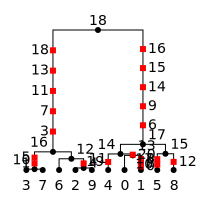

In [131]:
demographic_events = [msprime.InstantaneousBottleneck(time=0.5, strength=1, population=0)]
tree_sequence = msprime.simulate(
    sample_size=10, Ne=1000, length=5e4, mutation_rate=5e-8, random_seed=30,demographic_events=demographic_events)

# Nucleotide diversity (pi)
print(tree_sequence.diversity()) 
# Number of segregating sites 
print(tree_sequence.segregating_sites(span_normalise=False))
# Tajima's D
print(tree_sequence.Tajimas_D())

IPython.display.SVG(tree_sequence.first().draw())


4e-06
1.0
-1.1117331765568994


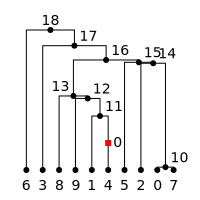

In [211]:
demographic_events = [msprime.PopulationParametersChange(time=0.5, growth_rate=0.05, population=0)]
tree_sequence = msprime.simulate(
    sample_size=10, Ne=1000, length=50e3, mutation_rate=5e-8, random_seed=31,demographic_events=demographic_events)
# Nucleotide diversity (pi)
print(tree_sequence.diversity()) 
# Number of segregating sites 
print(tree_sequence.segregating_sites(span_normalise=False))
# Tajima's D
print(tree_sequence.Tajimas_D())

IPython.display.SVG(tree_sequence.first().draw())

## Simulating under human demographic models using stdpopsim

In order to do more realistic simulations for human populations, we want to use demographic models inferred from real data. `stdpopsim` is a software that uses `msprime` to do according to pre-defined demographic models. The `stdpopsim` tutorial is located here (https://stdpopsim.readthedocs.io/en/latest/tutorial.html).  

To run stdpopsim we are first going to pick the species (humans) and the genetic map. Here we are simulating 5% of chromosome 2 (approximately 12 Mb). The demographic model is the "OutOfArfica_3G09" model which allows us to sample individuals from either present day YRI, CEU, and CHB populations. Here we will simulate 50 samples from each population. The output is the same tree sequence object we saw in the msprime examples above.   

In [168]:
import stdpopsim
import json

species = stdpopsim.get_species("HomSap")
contig = species.get_contig("chr2", length_multiplier=0.05)
model = species.get_demographic_model('OutOfAfrica_3G09')
samples = model.get_samples(50, 50, 50) #(YRI, CEU, CHB)
engine = stdpopsim.get_engine('msprime')
ts = engine.simulate(model, contig, samples, seed=16)

**Question** Use the stdpopsim catalog to look up details of the three population out of Africa model (https://stdpopsim.readthedocs.io/en/latest/catalog.html#sec-catalog). What the population size of CHB after the EU/AS split? What is the growth rate of CHB after the split? 

**Answer**

Now that we have the tree sequence object for our simulation let's calculate some summary statistics.  

**Question** Which population do you think will have the most segregating sites and why? 

**Answer:**

Let's do simulations to check our intuition. We will first define our three population samples. YRI are samples 1-50, CEU are 51-100, and CHB are 101-150. We can then tell `tskit` to calculate the number of segregating sites separately for each population.

In [169]:
YRI = ts.samples()[:50]
CEU = ts.samples()[50:100]
CHB = ts.samples()[100:150]

print(ts.segregating_sites(span_normalise=False,sample_sets=[YRI,CEU,CHB]))

[27690. 17838. 17336.]


**Question** Which population do you think will have highest pairwise diversity? Give your prediction and explain your reasoning. Use the `tskit` we used above for caclulating pariwise diversity to check your prediction. 

**Answer** 

In [172]:
## your code goes here
print(ts.diversity(sample_sets=[YRI,CEU,CHB]))

[0.0004457  0.00032238 0.00032145]


**Question** Given what you have just calculated and what you know about human population history, which population do you think will have the highest Tajima's D value? Which one the lowest? Explain your thinking then check your prediction. 

**Answer** 

In [171]:
# your code goes here 
print(ts.Tajimas_D(sample_sets=[YRI,CEU,CHB]))

[-0.45214072 -0.05736845  0.03649163]


**Question** Below is code to extract the genotype matrix for each population. Use these genotype matrices and the function you wrote above to plot the SFS for all populations and comment on differences that you see. Bonus if you can plot the SFS on a log-log scale. 

**Answer** 

In [180]:
G = ts.genotype_matrix()
G = np.int8(G)

G_YRI = G[:,0:50]
G_CEU = G[:,50:100]
G_CHB = G[:,100:150]

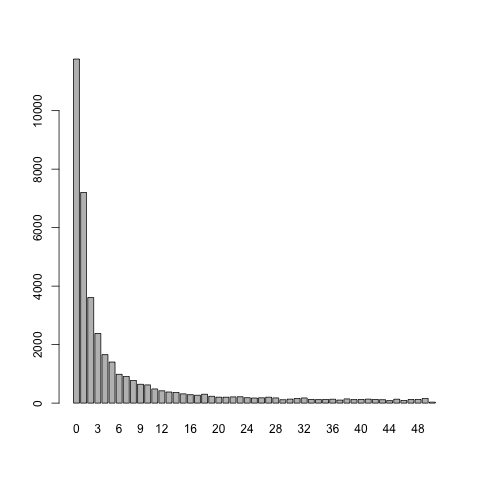

In [192]:
%%R -i G_CHB,G_YRI,G_CEU
# SFS G_YRI
barplot(SFS(G_YRI))

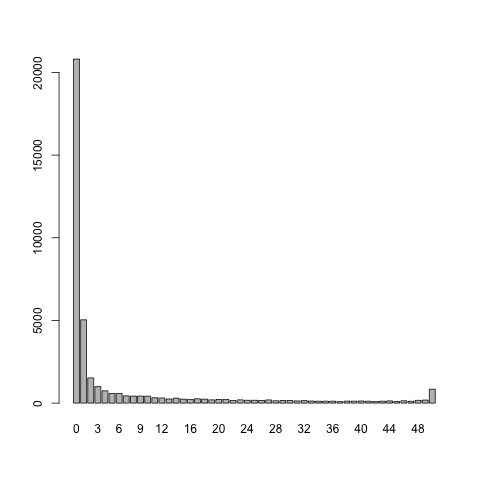

In [184]:
%%R -i G_CHB,G_YRI,G_CEU
# SFS G_CEU
barplot(SFS(G_CEU))

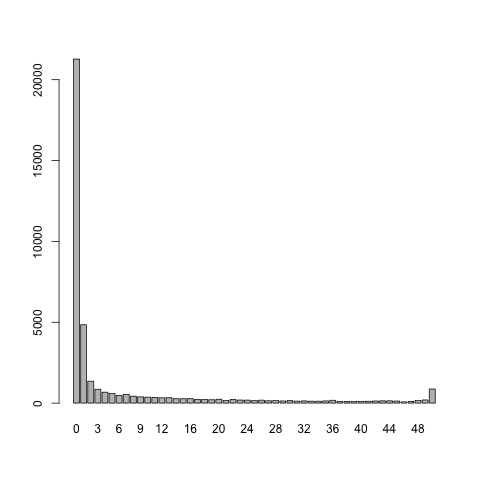

In [185]:
%%R -i G_CHB,G_YRI,G_CEU
# SFS G_CHB
barplot(SFS(G_CHB))

In [ ]:
# python code goes here 